                                 United Nations Millenium Development Goals
                                            DriveData Competition

                        Data Exploration/Viz, Model Construction, and Goal Prediction
                                              by Yuseof Jaber
                                              
 while the world was on hold and the people arund me found solace in parties, I found a sense of purposeful
      contribution in the data that helps paint a picture of the world. For the first time I felt 
 I had crossed the border between simply restating the problems of the world to those who already understood them,
to actually helping to understand these problems and learn how to convey them, use and implement them, 
                                        and push action over complaint



Material that aided me in this project:

    1. Sequences, Time Series, and Predictions (Coursera and DeepLearning.ai)
        (https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction)

In [1]:
#imports

#data manipulation 
import numpy as np
import pandas as pd

#graphing
import seaborn as sns
import matplotlib.pyplot as plt
#import prettyplotlib as pplt

#imputing
from sklearn.impute import KNNImputer


In [2]:
#Read Data from CSV files
data = pd.read_csv('./data/TrainingSet.csv', index_col = 0)
submission = pd.read_csv('./SubmissionRows.csv', index_col = 0)
data_original = data

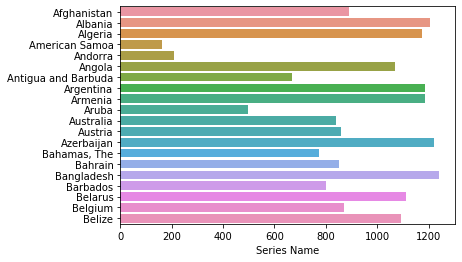

In [3]:
#data exploration

#214 countries in the dataset
countries = data['Country Name'].unique()

#print(countries)

#get the MDGs from the submission file
mdgs = submission.index

#Exploring Targets for prediction
targets_index = data.loc[mdgs].index
prediction_rows = data.loc[mdgs]

#Amount of rows (indicators?) per country
rows_country = data.groupby('Country Name')['Series Name'].count()

#Just to get an idea of data collected for each country
sns.barplot(y = countries[:20], x = rows_country[:20])

#data.sort_values('Country Name').groupby('Country Name').head()
#data.groupby('Country Name')

#data[['Series Name','Country Name']].head()
#targets[['Series Name','Country Name']].head()

In [4]:
#Summary of the goals for all the countries in the dataset
goals_by_country = prediction_rows.groupby('Country Name')[['Country Name','Series Name']]

def get_targets_and_indicators_by_country(country, dataset, mdgs):
    
    '''
    Aptly named function 
    
    args:
        country -- the country being queried
        dataset -- which dataset to pull indicators from
        mdgs    -- indices (from submission csv) 
    
    returns:
        country_indicators -- DataFrame containing all rows from dataset for country specified
        country_targets    -- DataFrame containing all rows that represent the targets to be predicted for country specified
    '''
    
    if (country not in data['Country Name'].values):
        print("*WARNING* Can't find %s in dataset, returning null values" % country)
        return None, None
        
    country_indicators = dataset[dataset['Country Name'] == country]
    country_targets = country_indicators.loc[set(mdgs.values) & set(country_indicators.index.values)]
    
    return  country_targets, country_indicators

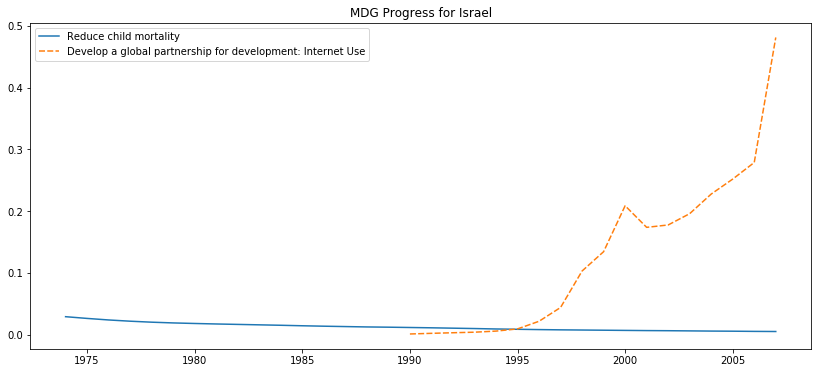

In [5]:
'''
---------------------------  PROGRESS TOWARDS MDGs ---------------------------------------

'''

targets, indicators = get_targets_and_indicators_by_country("Israel", data, mdgs)
country = targets['Country Name'].iloc[0]

years = [x for x in range(1972, 2008, 1)]

#Make series name the index for plot legend
targets = targets.set_index('Series Name')

#remove non numeric info
targets = targets.select_dtypes(exclude = ['object'])

#'1972 yr[1972]' ---> 1972
targets.columns = years

#flip so year is x-axis
targets = targets.transpose()

#get rid of nulls
targets = targets.mask(targets.isnull())

#plot config
plt.figure(figsize=(14, 6))
plt.title('MDG Progress for %s' % country)


line = sns.lineplot(data = targets)


In [6]:
import statistics 
#Get overlapping Indicators between countries
target_Z, indic_Z = get_targets_and_indicators_by_country("American Samoa", data, mdgs)
A_list = indicators['Series Name'].values.tolist()
Z_list = indic_Z['Series Name'].values.tolist()

overlap = set(A_list) & set(Z_list)


'''
--------------------  INFORMATION ABOUT INDICATORS --------------------

I will be using the value 934 as a baseline number of indicators (and 
therefore features for the models). 

'''

max = data.groupby('Country Name')['Series Name'].count().max()    #1255
min = data.groupby('Country Name')['Series Name'].count().min()    #13
avg = data.groupby('Country Name')['Series Name'].count().mean()   #913
mode = data.groupby('Country Name')['Series Name'].count().mode()  #887, 934, 1196, 1212


In [7]:
#Get all possible targets to be predicted
#x = data.loc[mdgs].groupby('Country Name')['Series Name'].count() == 6
target_data = data.loc[mdgs]
target_names = target_data['Series Name'].unique()
target_names.sort()


------------------------------------------------------------------------------------------------------------------


                                INDICATOR --> GOAL GENERALIZED MODEL
                                        
            x_input  -->  vec_indicators =  [ i1, i2 ... i(no_indicators_for_model)]
            y_output -->  vec_goals =       [ goal 1. . . goal 7]    

    This disregards the country from where the indicators are taken and seeks to find a more general relationship between the indicators and the goals for a specific year. Years are also ditched (after creating the DataFrames so that indicators map to the goal value for that year)
    

------------------------------------------------------------------------------------------------------------------


In [8]:
import datetime 

def convert_to_datetime(str):
   
    '''
    This function will be used in order to map the years in format '1972 [YR1972]' to a datetime object 
    '1972 - 01 - 01'
    '''
    
    str = str.split(' ')[0]
    str = datetime.datetime.strptime(str, '%Y')
    return str

In [9]:
def get_indicators_for_model(indicator_threshold, indicator_dataframe):
    
    '''
    Sorts indicators by the amount of countries that have them, then picks all of the indicators until 
    it reaches one with indicator_threshold number of countries 
    
    args:
        indicator_threshold -- the minimum amount of countries with a given indicator
        indicator_dataframe -- dataframe to pull indicators from
        
    returns:
        most_common_indicators -- DataFrame with all indicators with count above indicator threshold
        
    '''
    
    #get(no_indicators_for_model) most common indicators in alphabetical order
    indicator_count = indicator_dataframe.groupby('Series Name')['Country Name'].count()
    indicator_count.sort_values(ascending = False)

    most_common_indicators = indicator_count[indicator_count >= indicator_threshold]
    most_common_indicators_list = most_common_indicators.index.sort_values().tolist()
    
    return most_common_indicators_list


In [10]:
def add_missing_indicators(feature_dataframe, indicators_list):
    
    '''
    Takes the feature dataframe, checks which indicators from the desired_indicators_list it doesn't have, 
    and adds Nan filled rows for each missing indicator

    args:
        feature_dataframe -- targets removed, indexed by [Country Name, Series Name]
        indicators_list -- returned from get_indicators_for_model

    '''

    #used for column names to populate dataframe for missing indicators
    years = feature_dataframe.columns

    #now add missing indicators and set values to nan for each country (NOTE! this can probably be done more efficiently)
    for country in countries:

        #get indicators for current country (as a DataFrame)
        current = feature_dataframe.loc[country]

        #determine which indicators are missing from current
        missing_indicators_list = set(indicators_list) - set(current.index.tolist())
        missing_count = len(missing_indicators_list)

        #create indices to match the multiindicies of the X_features multiindex df
        index_arrays = [np.array([str(country) for x in range(missing_count)]), np.array(list(missing_indicators_list))]

        #create a matrix of Nan values to be used for the missing indicator values
        nan_matrix = np.empty((missing_count, len(years)))
        nan_matrix[:] = np.nan

        #create a multiindex df for the missing indicators to append to the X_features df
        missing_indicators_midf = pd.DataFrame(nan_matrix, index = index_arrays, columns = years)
        feature_dataframe = feature_dataframe.append(missing_indicators_midf)

    #appending adds rows to end of df rather than end of rows with same index. Sorting fixes this
    feature_dataframe = feature_dataframe.sort_index()

    #Check to see that all countries have the same number of indicators
    checker = feature_dataframe.reset_index().groupby('Country Name')['Series Name'].count()
    assert(checker.iloc[0] > 0)
    assert(checker.sum() == checker.iloc[0] * len(checker))
    
    #reformat years so they are in datetime format
    reformatted_cols = feature_dataframe.columns.map(convert_to_datetime).tolist()
    feature_dataframe.columns = reformatted_cols

    #essentially swapping the years columns with the 'Series Name' index. In a sense, transposing
    feature_dataframe_stacked = feature_dataframe.stack(dropna = False)
    feature_dataframe = feature_dataframe_stacked.unstack(1)
    
    return feature_dataframe

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

#TODO: Fix logic for nan checking

def split_and_impute(features, targets, x_strategy, y_strategy, test_size):
    '''
    Vary impute methods and test_size to allow for testing models with multiple train and test sets
    
    args:
        features -- indicator dataframe (no index)
        targets  -- goal dataframe (no index)
        x_strategy -- how to impute indicators
        y_strategy -- how to impute goals 
        test_size -- for splitting data
    
    returns:
        X_train_imputed
        X_test_imputed
        y_train_imputed
        y_test_imputed
    '''
    
    t_check = True
    t1, t2, t3, t4 =  None, None, None, None 
    
    while(t_check):
        #split into sets, make sure the test split doesn't create any all-nan columns in subsets (making imputing impossible)
        resplit_not_successful = True
        X_train, X_test, y_train, y_test = None, None, None, None

        while(resplit_not_successful == True):
            X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = test_size, shuffle = True)
            sets_for_na_check = [X_train, X_test, y_train, y_test]   

            #false if all nan, meaning resplit is desired
            for i in sets_for_na_check:
                resplit_not_successful = resplit_not_successful and i.notna().any().any()

            #exit when resplit_not_successful is false 
            resplit_not_successful = resplit_not_successful != True

        #Add on to functionality later, for now x will always be simple imputer and y fillna()

        #Features
        if(x_strategy == 'simple_mean'):
            imputer_x = SimpleImputer(strategy = 'mean')

        elif(x_strategy == 'simple_median'):
            imputer_x = SimpleImputer(strategy = 'median')

        elif(x_strategy == 'simple_frequent'):
            imputer_x = SimpleImputer(strategy = 'most_frequent')

        X_train_imputed = pd.DataFrame(imputer_x.fit_transform(X_train), columns = X_train.columns)
        X_test_imputed  = pd.DataFrame(imputer_x.transform(X_test), columns = X_test.columns)

        #Targets
        if(y_strategy == 'fill_mean'):
            y_train_imputed = y_train.fillna(y_train.mean())
            y_test_imputed = y_test.fillna(y_test.mean())

        elif(y_strategy == 'fill_median'):
            y_train_imputed = y_train.fillna(y_train.median())
            y_test_imputed = y_test.fillna(y_test.median())

        elif(y_strategy == 'fill_mode'):
            y_train_imputed = y_train.fillna(y_train.mode())
            y_test_imputed = y_test.fillna(y_test.mode())


        #make sure no nan, if so call function again
        t1, t2, t3, t4 =  pd.isnull(X_train_imputed).any().any(), pd.isnull(X_test_imputed).any().any(), pd.isnull(y_train_imputed).any().any(), pd.isnull(y_test_imputed).any().any()
        t_check = t1 or t2 or t3 or t4
            
    print('t_check passed if false: ', t_check)
    return X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed, y_test, y_train


In [12]:
def knn_interpolate(filled_indicators_df, n_rows, n_knn_neighbors, d, knn_weights = None):
    '''
    Use KNN imputation to fill in a subset of the rows for each country. Then use interpolation to fill in
    the rest of the rows (so that they make sense as a progression over time)
    
    args:
        filled_indicators_df -- unimputed, indicator dataframe with missing indicators filled in
        n_rows -- how many vectors/rows for each country to use for KNN imp
        n_knn_neighbors -- how many neighbors to consider for knn imp
        knn_weights -- knn imputer paramter. 'uniform' by default, otherwise 'distance'
        
    returns:
        X_train_imputed
        X_test_imputed
        y_train_imputed
        y_test_imputed
    '''

    #check if passed dataframe has any columns with all nan values
    if(X_features_filled.isnull().all().any() == True):
        print("The dataframe contains columns with all nan values")
    
    
    #default knn_weights parameter
    if(knn_weights in (['uniform', 'distance']) == False):
        knn_weights == 'uniform'
        
    #1. Pick vectors for KNN imputation
    n_rows -= 4 #since I'm already adding the first and last years

    checker = True
    
    while(checker == True):
        
        n_rows += 3
            
        print("increased rows to: ", n_rows)
        
        grabbed = [years[i] for i in [0, -1]]

        for i in range(1, n_rows):
            grabbed.append(years[i*(36//n_rows)])

        #2. Pool together into new dataframe and use knn imputation
        df_for_knn_imputation = filled_indicators_df.loc[(slice(None), (grabbed)), :]
        
        #Check for all null columns (non imputable)
        if(df_for_knn_imputation.isnull().all().any() == True):
            print('----------- *! Warning !* -------------')
            print('Some columns have all nan values, fetching another few rows')
            print('total rows: ', df_for_knn_imputation.shape[0])
            d[n_rows] = df_for_knn_imputation.isnull().sum(axis = 0)
            
            #find which columns have all nan values
            #print("Count: ")
            #print(df_for_knn_imputation.isnull().sum(axis = 0))
            #nan_count = df_for_knn_imputation.isnull().sum(axis = 0)
            #print(nan_count[nan_count == ])
            #df_for_knn_imputation[df_for_knn_imputation.isnull().sum(axis = 0) == df_for_knn_imputation.shape[0]]

        else:
            checker = False
    
    print('Sucess: no columns have all nan values')
    print("Years: ", grabbed)
    
    imputer = KNNImputer(n_neighbors = n_knn_neighbors, weights = knn_weights)
    features_filled_knn = imputer.fit_transform(df_for_knn_imputation)

    #3. Return to orignal df
    
    #4. perform time interpolation

    return features_filled_knn

In [16]:
#I deleted these columns because they had so many nan values it made knn imputation difficult

print(X_features_filled.shape)
#del X_features_filled['2005 PPP conversion factor, GDP (LCU per international $)']
#del X_features_filled['2005 PPP conversion factor, private consumption (LCU per international $)']
#del X_features_filled['GEF benefits index for biodiversity (0 = no biodiversity potential to 100 = maximum)']


NameError: name 'X_features_filled' is not defined

In [92]:
d = {}
features_filled_knn = knn_interpolate(X_features_filled, 15, 15, d,knn_weights = 'distance')

increased rows to:  14
Sucess: no columns have all nan values
Years:  ['1972 [YR1972]', '2007 [YR2007]', '1974 [YR1974]', '1976 [YR1976]', '1978 [YR1978]', '1980 [YR1980]', '1982 [YR1982]', '1984 [YR1984]', '1986 [YR1986]', '1988 [YR1988]', '1990 [YR1990]', '1992 [YR1992]', '1994 [YR1994]', '1996 [YR1996]', '1998 [YR1998]']


!
!
!
!
!
---------->
    Left off here
    
    Working on knn imputation
    
    This could still work, I just have to work out which columns have all nan values after adding more rows
    The code below helps figure that out, but I didn't get the chance to work that into the knn_interpolate 
    function 
    
    Now I have to test the knn, see if the values it comes up with make sense, then do the interpolation

In [97]:
features_filled_knn = pd.DataFrame(features_filled_knn, columns = X_features_filled.columns)
features_filled_knn.head(15)

Series Name,Adjusted savings: consumption of fixed capital (current US$),Adjusted savings: energy depletion (% of GNI),Adjusted savings: energy depletion (current US$),Adjusted savings: mineral depletion (% of GNI),Adjusted savings: mineral depletion (current US$),Agricultural land (% of land area),Agricultural land (sq. km),Arable land (% of land area),Arable land (hectares per person),Arable land (hectares),...,Surface area (sq. km),Telephone lines,Telephone lines (per 100 people),Terrestrial and marine protected areas (% of total territorial area),Terrestrial protected areas (% of total land area),Total natural resources rents (% of GDP),"Tuberculosis case detection rate (%, all forms)",Urban population,Urban population (% of total),Urban population growth (annual %)
0,1.296592e+08,1.369047,2.233065e+07,0.000000,0.0,58.332183,380460.0,12.127624,0.679298,7910000.0,...,652230.0,244448.964215,4.524613,2.450309,3.020572,4.516957,42.574590,1389151.0,11.9298,6.634620
1,1.337295e+08,2.999907,6.606462e+07,0.000000,0.0,58.335250,380480.0,12.127624,0.644473,7910000.0,...,652230.0,343910.152623,6.880064,5.427830,6.421827,7.149039,57.754882,1574530.0,12.8286,6.101041
2,1.683164e+08,2.475435,6.463635e+07,0.000000,0.0,58.335250,380480.0,12.127624,0.617640,7910000.0,...,652230.0,22200.000000,0.173345,5.415087,5.664223,7.103324,54.453778,1761884.0,13.7574,5.558187
3,1.824045e+08,2.546521,8.584604e+07,0.000000,0.0,58.338316,380500.0,12.127624,0.599261,7910000.0,...,652230.0,25300.000000,0.191673,5.048730,5.486294,6.736402,56.189867,1942479.0,14.7162,4.570840
4,1.567716e+08,4.408676,1.638508e+08,0.000000,0.0,58.336783,380490.0,12.127624,0.600132,7910000.0,...,652230.0,25800.000000,0.195745,5.157893,5.087068,10.621110,50.169505,2066033.0,15.6750,2.525932
5,8.111022e+09,3.893667,1.683107e+08,0.022273,0.0,58.344449,380540.0,12.127624,0.626064,7910000.0,...,652230.0,28000.000000,0.221616,11.035549,12.222699,10.377873,77.018591,2043225.0,16.1718,-1.025012
6,7.598523e+09,2.337866,1.660111e+08,0.019026,0.0,58.344449,380540.0,12.127624,0.667274,7910000.0,...,652230.0,30000.000000,0.253075,10.479760,11.775211,10.424745,76.636716,1975930.0,16.6686,-1.716968
7,5.127959e+09,2.023211,1.414699e+08,0.011827,0.0,58.344449,380540.0,12.127624,0.702335,7910000.0,...,652230.0,32000.000000,0.284130,8.541804,10.826897,9.189182,73.443540,1933198.0,17.1650,-0.883681
8,3.622687e+09,0.913826,4.824421e+07,0.027443,0.0,58.322984,380400.0,12.127624,0.718220,7910000.0,...,652230.0,34000.000000,0.308716,12.165533,12.792429,5.339432,64.254661,1945067.0,17.6610,0.963358
9,4.593596e+08,0.069900,9.005472e+06,0.006043,0.0,58.322984,380400.0,12.127624,0.674271,7910000.0,...,652230.0,36200.000000,0.308579,0.366883,0.366883,6.647735,20.000000,2130033.0,18.1570,5.872341


In [71]:
X_features_filled.loc['Afghanistan']

Series Name,Adjusted savings: consumption of fixed capital (current US$),Adjusted savings: energy depletion (% of GNI),Adjusted savings: energy depletion (current US$),Adjusted savings: mineral depletion (% of GNI),Adjusted savings: mineral depletion (current US$),Agricultural land (% of land area),Agricultural land (sq. km),Arable land (% of land area),Arable land (hectares per person),Arable land (hectares),...,Surface area (sq. km),Telephone lines,Telephone lines (per 100 people),Terrestrial and marine protected areas (% of total territorial area),Terrestrial protected areas (% of total land area),Total natural resources rents (% of GDP),"Tuberculosis case detection rate (%, all forms)",Urban population,Urban population (% of total),Urban population growth (annual %)
1972 [YR1972],NaN,1.369047,2.233065e+07,0.0,0.0,58.332183,380460.0,12.127624,0.679298,7910000.0,...,652230.0,NaN,NaN,NaN,NaN,4.516957,NaN,1389151.0,11.9298,6.634620
1973 [YR1973],NaN,1.498578,2.654146e+07,0.0,0.0,58.335250,380480.0,12.127624,0.661020,7910000.0,...,652230.0,NaN,NaN,NaN,NaN,4.686652,NaN,1481339.0,12.3792,6.425364
1974 [YR1974],NaN,2.999907,6.606462e+07,0.0,0.0,58.335250,380480.0,12.127624,0.644473,7910000.0,...,652230.0,NaN,NaN,NaN,NaN,7.149039,NaN,1574530.0,12.8286,6.101041
1975 [YR1975],NaN,2.846491,6.882184e+07,0.0,0.0,58.335250,380480.0,12.127624,0.630189,7910000.0,...,652230.0,21500.0,0.171290,NaN,NaN,7.568906,NaN,1666627.0,13.2780,5.684501
1976 [YR1976],NaN,2.475435,6.463635e+07,0.0,0.0,58.335250,380480.0,12.127624,0.617640,7910000.0,...,652230.0,22200.0,0.173345,NaN,NaN,7.103324,NaN,1761884.0,13.7574,5.558187
1977 [YR1977],NaN,2.403162,7.252207e+07,0.0,0.0,58.338316,380500.0,12.127624,0.606853,7910000.0,...,652230.0,22200.0,0.170318,NaN,NaN,6.683094,NaN,1855690.0,14.2368,5.187290
1978 [YR1978],NaN,2.546521,8.584604e+07,0.0,0.0,58.338316,380500.0,12.127624,0.599261,7910000.0,...,652230.0,25300.0,0.191673,NaN,NaN,6.736402,NaN,1942479.0,14.7162,4.570840
1979 [YR1979],NaN,2.970677,1.121651e+08,0.0,0.0,58.336783,380490.0,12.127624,0.596660,7910000.0,...,652230.0,25300.0,0.190841,NaN,NaN,7.901594,NaN,2014500.0,15.1956,3.640603
1980 [YR1980],NaN,4.408676,1.638508e+08,0.0,0.0,58.336783,380490.0,12.127624,0.600132,7910000.0,...,652230.0,25800.0,0.195745,NaN,NaN,10.621110,NaN,2066033.0,15.6750,2.525932
1981 [YR1981],NaN,4.878848,1.732730e+08,0.0,0.0,58.342916,380530.0,12.127624,0.610161,7910000.0,...,652230.0,31700.0,0.244527,NaN,NaN,10.522539,NaN,2064276.0,15.9234,-0.085078


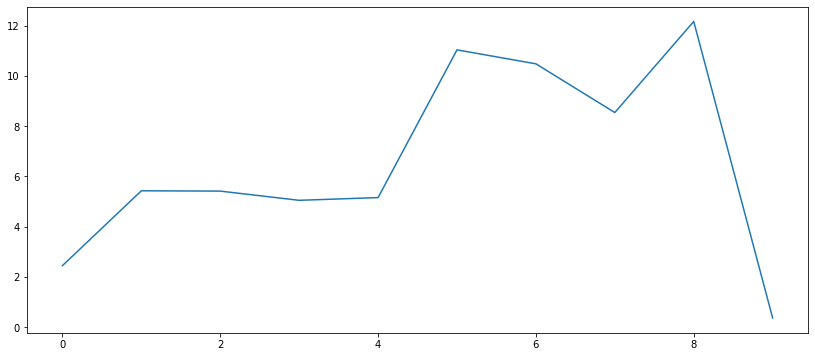

In [98]:
plt.figure(figsize=(14, 6))

line = sns.lineplot(data = features_filled_knn['Terrestrial and marine protected areas (% of total territorial area)'][:10])

In [13]:
def compute_unimputed_cost(y_unimputed, y_hat, y_test_imputed, error_type):
    '''
    Get boolean array of non-nan values from the unimputed target df (y_unimputed), access corresponding elements from y_hat and y_test, and compare these
    two df's, giving the actual performance
    
    args:
        y_unimputed -- target dataframe before imputing
        y_hat -- predicted target array 
        y_test_imputed -- from train test split (imputed)
        error_type -- mean squared, absolute, etc
    
    returns:
        cost 
    '''
    
    bool_array = y_unimputed.isna()
    y_hat_filtered = y_hat[bool_array]
    y_test_filtered = y_test_imputed.values[bool_array]
    
    cost = 0
    
    if(error_type == 'absolute'):
        cost = mean_absolute_error(y_hat_filtered, y_test_filtered)
    
    elif(error_type == 'squared'):
        cost = mean_squared_error(y_hat_filtered, y_test_filtered)
    
    return cost, y_hat_filtered, y_test_filtered


In [13]:
'''-------------------------------------------------------------------------------------------------------------------------

                        Step 0: A - Get targets and indicators in seperate dataframes
                                            and format indices

                                B - Fill target dataframe with missing targets for
                                                each country

-------------------------------------------------------------------------------------------------------------------------'''

#A

#Pull data from original csv and seperate mdgs from indicators
mdgs = submission.index
mdgs_for_i2g_model = data_original.loc[mdgs]

target_names = mdgs_for_i2g_model['Series Name'].unique()
indicators_for_i2g_model = data_original[data_original['Series Name'].isin(target_names) == False]
indicators_for_i2g_model.sort_values(by = ['Country Name', 'Series Name'])

#Get data_original into proper DataFrame format for i2g 

#Create a multi index DataFrame for legibility
X_features = indicators_for_i2g_model.set_index(['Country Name', 'Series Name'])
X_features = X_features.drop(['Series Code'], axis = 1)
X_features = X_features.sort_index()

#make sure there is no overlap between mdgs and indicators
assert(set(X_features.index.get_level_values(1)) & set(mdgs_for_i2g_model['Series Name'].values) == set())


#B

#create a goals df
targets = mdgs_for_i2g_model.set_index(['Country Name', 'Series Name'])
targets = targets.drop('Series Code', axis = 1)

#!NOTE! - targets does not contain all countries as the submission does not require goal predictions for every country
# try adding empties for missing countries, then try again and disregard missing countries

countries_in_targets = targets.index.unique()
missing_countries = set(countries) - set(countries_in_targets)

years = X_features.columns

nan_row = np.empty((1, len(years)))
nan_row[:] = np.nan

#for missing countries
not_found = False

#add missing targets to each country (this is similar enough to what I did for X_features missing indicators. maybe this can be a function?
for country in countries:
    
    #get current country targets (this might fail if country isn't in mdgs)
    try: 
        current = targets.loc[country]
    except:
        not_found = True

    #which targets are missing?
    if(not_found == False):
        missing_targets = set(target_names) - set(current.index.tolist())
    
    #country wasn't in mdgs, so its missing all targets
    else:
        missing_targets = target_names
        
    #create nan dataframe for missing targets and append to targets df
    missing_targets_indices = [np.array([country for x in range(len(missing_targets))]), np.array(list(missing_targets))]

    nan_matrix = np.empty((len(missing_targets), len(years)))
    nan_matrix[:] = np.nan

    missing_targets_midf = pd.DataFrame(nan_matrix, index = missing_targets_indices, columns = years)
    targets = targets.append(missing_targets_midf)
    not_found = False
    
#fix append issue (so added vectors appear with grouped country)
targets = targets.sort_index()

#reformat years so they are in datetime format
reformatted_cols = targets.columns.map(convert_to_datetime).tolist()
targets.columns = reformatted_cols

#essentially swapping the years columns with the 'Series Name' index. In a sense, transposing
targets_stacked = targets.stack(dropna = False)
targets = targets_stacked.unstack(1)

In [99]:
'''-------------------------------------------------------------------------------------------------------------------------

                        Step 1: get only indicators from each country that are in 
                                        the most_common_indicator_list

-------------------------------------------------------------------------------------------------------------------------'''

most_common_indicators_list = get_indicators_for_model(200, indicators_for_i2g_model)
X_features_most_common = X_features[X_features.index.isin(most_common_indicators_list, level=1)]

print('Number of indicators: %d' % len(most_common_indicators_list))

Number of indicators: 80


In [100]:
'''-------------------------------------------------------------------------------------------------------------------------

                        Step 2: fill indicator dataframe with missing indicators
                                            for each country

-------------------------------------------------------------------------------------------------------------------------'''

X_features_filled = add_missing_indicators(X_features_most_common, most_common_indicators_list)

# -----------------------------------------------------------------------------------------------------------¶

                            Feat Selec SANBOX

In [101]:
non_null = X_features_filled[X_features_filled.isnull().any(axis = 1) == False]

In [102]:
non_null

,Series Name,Adjusted savings: consumption of fixed capital (current US$),Adjusted savings: energy depletion (% of GNI),Adjusted savings: energy depletion (current US$),Adjusted savings: mineral depletion (% of GNI),Adjusted savings: mineral depletion (current US$),Agricultural land (% of land area),Agricultural land (sq. km),Arable land (% of land area),Arable land (hectares per person),Arable land (hectares),...,Surface area (sq. km),Telephone lines,Telephone lines (per 100 people),Terrestrial and marine protected areas (% of total territorial area),Terrestrial protected areas (% of total land area),Total natural resources rents (% of GDP),"Tuberculosis case detection rate (%, all forms)",Urban population,Urban population (% of total),Urban population growth (annual %)
Country Name,,,,,,,,,,,,,,,,,,,,,,
Austria,2000-01-01,2.887231e+10,0.153379,2.896231e+08,0.000000,0.000000e+00,41.115828,33900.0,16.967859,0.174623,1399000.0,...,83870.0,3997000.0,49.836277,23.524380,23.524380,0.424076,87.0,5271610.0,65.800,0.240462
Denmark,2000-01-01,2.529054e+10,2.037055,3.192029e+09,0.000000,0.000000e+00,62.385105,26470.0,53.759133,0.427184,2281000.0,...,43090.0,3835000.0,71.839578,20.419051,17.840577,2.550527,87.0,4544013.0,85.100,0.362672
Finland,2000-01-01,1.880413e+10,0.000000,0.000000e+00,0.012678,1.532276e+07,7.281920,22180.0,7.167011,0.421737,2183000.0,...,338150.0,2848809.0,55.033689,12.999379,12.725519,1.734587,87.0,4253964.0,82.183,0.504944
France,2000-01-01,1.567459e+11,0.026083,3.508664e+08,0.000013,1.751010e+05,54.240692,297060.0,33.669911,0.302736,18440000.0,...,549190.0,33987106.0,57.397955,17.440711,16.888630,0.206675,80.0,46837557.0,76.895,1.201725
Germany,2000-01-01,2.776304e+11,0.112360,2.097165e+09,0.000084,1.569907e+06,48.912452,170680.0,33.827196,0.143581,11804000.0,...,357030.0,50220000.0,60.134740,42.146564,41.530968,0.260872,87.0,60069483.0,73.067,0.075506
Greece,2000-01-01,1.418774e+10,0.032731,4.088415e+07,0.014064,1.756697e+07,66.167572,85290.0,21.264546,0.251065,2741000.0,...,131960.0,5659274.0,51.509368,14.125669,21.973602,0.104205,87.0,6521667.0,59.736,0.470648
Iceland,2000-01-01,9.838500e+08,0.000000,0.000000e+00,0.000000,0.000000e+00,18.842893,18890.0,1.286783,0.458740,129000.0,...,103000.0,196336.0,69.817292,7.414171,9.961382,0.000000,87.0,259836.0,92.401,1.536162
Israel,2000-01-01,1.458242e+10,0.001012,1.153783e+06,0.000000,0.000000e+00,26.155268,5660.0,15.619224,0.053745,338000.0,...,22070.0,2974000.0,49.453657,14.737009,17.428677,0.004302,87.0,5735757.0,91.203,2.716257
Italy,2000-01-01,1.606136e+11,0.175657,1.924573e+09,0.000022,2.424823e+05,53.167182,156370.0,28.829350,0.148906,8479000.0,...,301340.0,27153000.0,47.648474,12.441963,17.206439,0.264425,87.0,38277624.0,67.222,0.134600


In [86]:
features_X = X_features_filled.reset_index().drop(['Country Name', 'level_1'], axis = 1)
targets_y = targets.reset_index().drop(['Country Name','level_1'], axis = 1)

In [108]:
#Code added 21-7-2020
#Feature Selection Using Filtering (Chi squared and Pearson Correlation)
#Guides: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
#https://www.datacamp.com/community/tutorials/feature-selection-python

'''
#aids_concat = aids_concat.fillna(method = 'bfill')
#aids_concat = aids_concat.fillna(0)

#Correlation to targets
cor = aids_concat.corr()
cor_target = abs(cor[target_names[3]])
relevant = cor_target[cor_target > 0.2]
relevant
#cor_target[cor_target.isnull() == False]
'''

target_names = targets.columns

aids = pd.DataFrame(targets_y[target_names[3]])
aids_concat = pd.concat([aids, non_null])

#drop null columns
aids_concat.dropna(axis = 1)
aids_concat






,Develop a global partnership for development: Internet Use,Adjusted savings: consumption of fixed capital (current US$),Adjusted savings: energy depletion (% of GNI),Adjusted savings: energy depletion (current US$),Adjusted savings: mineral depletion (% of GNI),Adjusted savings: mineral depletion (current US$),Agricultural land (% of land area),Agricultural land (sq. km),Arable land (% of land area),Arable land (hectares per person),...,Surface area (sq. km),Telephone lines,Telephone lines (per 100 people),Terrestrial and marine protected areas (% of total territorial area),Terrestrial protected areas (% of total land area),Total natural resources rents (% of GDP),"Tuberculosis case detection rate (%, all forms)",Urban population,Urban population (% of total),Urban population growth (annual %)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(Spain, 2000-01-01 00:00:00)",NaN,7.367791e+10,0.008182,4.708101e+07,0.000491,2.828193e+06,59.651303,297660.0,26.853707,0.332810,...,505000.0,17104000.0,42.459780,23.146104,26.618363,0.127534,87.0,30705534.0,76.262,0.946918
"(Sweden, 2000-01-01 00:00:00)",NaN,3.132850e+10,0.000000,0.000000e+00,0.011363,2.786039e+07,7.683872,31530.0,6.587220,0.304663,...,450300.0,6056000.0,68.257508,12.058972,12.916399,0.937256,87.0,7454878.0,84.026,0.208658
"(Switzerland, 2000-01-01 00:00:00)",NaN,4.732738e+10,0.000000,0.000000e+00,0.000000,0.000000e+00,38.300000,15320.0,10.325000,0.057487,...,41280.0,5235733.0,73.067808,22.255104,22.255104,0.128042,87.0,5267636.0,73.322,0.492150
"(Turkey, 2000-01-01 00:00:00)",NaN,1.746431e+10,0.149420,3.923261e+08,0.021091,5.537843e+07,52.595403,404790.0,30.957733,0.377146,...,783560.0,18395171.0,29.118040,2.080666,2.025011,0.373504,87.0,40899792.0,64.741,2.296236


# -----------------------------------------------------------------------------------------------------------

                                TABLEAU SANBOX

In [59]:
X_reset = X_features_filled.reset_index()

In [60]:
X_reset = X_reset.set_index('Country Name')

In [61]:
X_reset.rename(columns = {'level_1':'Year'}, inplace = True)

In [62]:
X_reset

Series Name,Year,Adjusted savings: consumption of fixed capital (current US$),Adjusted savings: energy depletion (% of GNI),Adjusted savings: energy depletion (current US$),Adjusted savings: mineral depletion (% of GNI),Adjusted savings: mineral depletion (current US$),Agricultural land (% of land area),Agricultural land (sq. km),Arable land (% of land area),Arable land (hectares per person),...,Surface area (sq. km),Telephone lines,Telephone lines (per 100 people),Terrestrial and marine protected areas (% of total territorial area),Terrestrial protected areas (% of total land area),Total natural resources rents (% of GDP),"Tuberculosis case detection rate (%, all forms)",Urban population,Urban population (% of total),Urban population growth (annual %)
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1972-01-01,NaN,1.369047,2.233065e+07,0.000000,0.000000e+00,58.332183,380460.0,12.127624,0.679298,...,652230.0,NaN,NaN,NaN,NaN,4.516957,NaN,1389151.0,11.9298,6.634620
Afghanistan,1973-01-01,NaN,1.498578,2.654146e+07,0.000000,0.000000e+00,58.335250,380480.0,12.127624,0.661020,...,652230.0,NaN,NaN,NaN,NaN,4.686652,NaN,1481339.0,12.3792,6.425364
Afghanistan,1974-01-01,NaN,2.999907,6.606462e+07,0.000000,0.000000e+00,58.335250,380480.0,12.127624,0.644473,...,652230.0,NaN,NaN,NaN,NaN,7.149039,NaN,1574530.0,12.8286,6.101041
Afghanistan,1975-01-01,NaN,2.846491,6.882184e+07,0.000000,0.000000e+00,58.335250,380480.0,12.127624,0.630189,...,652230.0,21500.0,0.171290,NaN,NaN,7.568906,NaN,1666627.0,13.2780,5.684501
Afghanistan,1976-01-01,NaN,2.475435,6.463635e+07,0.000000,0.000000e+00,58.335250,380480.0,12.127624,0.617640,...,652230.0,22200.0,0.173345,NaN,NaN,7.103324,NaN,1761884.0,13.7574,5.558187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe,2003-01-01,5.984790e+08,0.178590,9.836209e+06,1.165485,6.419160e+07,40.454957,156500.0,9.383482,0.286433,...,390760.0,300921.0,2.374486,28.008692,28.008692,5.261810,56.0,4438019.0,35.0192,1.462004
Zimbabwe,2004-01-01,6.052990e+08,1.106713,6.111326e+07,2.272432,1.254848e+08,41.359700,160000.0,9.771229,0.297801,...,390760.0,317000.0,2.497430,28.008692,28.008692,7.748060,55.0,4498365.0,35.4396,1.350589
Zimbabwe,2005-01-01,5.817043e+08,0.820684,4.497854e+07,2.331113,1.277594e+08,41.618198,161000.0,10.029727,0.305257,...,390760.0,328000.0,2.580526,28.008692,28.008692,7.489343,50.0,4558017.0,35.8600,1.317366


In [64]:
X_reset.to_excel(r'C:\Users\Yousef\Desktop\export_df_3.xlsx')

# -----------------------------------------------------------------------------------------------------------


                                    INTERPOLATION SANBOX

In [20]:
#This successfully splits the X_features_filled unimputed indicator dataframe into seperate DFs by country, 
#then interpolates them. It doesn't yet handle back filling 

forward_interpolated_dict = {"X_features_filled_unimputed": X_features_filled}
for country in countries:
    forward_interpolated_dict[country] = X_features_filled.loc[country].interpolate(method = 'time', axis = 0)

forward_interpolated_dict['Afghanistan'].isnull().sum(axis = 0).tolist()

#Left off here: After interpolating, maybe check all the countries and see if they have any columns
#for which all countries have a higher than threshold amount of nan values for that indicator, in which case
#drp that bitch

#make sure country_col is correct length
range_amount = len(forward_interpolated_dict['Afghanistan'].index)

#append country name column for later regrouping by country
country_col = ['Afghanistan' for x in range(range_amount)]
interpolated_indicators_restitched = forward_interpolated_dict['Afghanistan']
interpolated_indicators_restitched['Country Name'] = country_col

#also, when knn imputing, maybe try and test outlier-ness to see if point makes sense
for item in forward_interpolated_dict:
    if(item != 'Afghanistan' and item != 'X_features_filled_unimputed'):
        to_be_concat = forward_interpolated_dict[item]
        to_be_concat['Country Name'] = [item for x in range(range_amount)]
        interpolated_indicators_restitched = pd.concat([interpolated_indicators_restitched, to_be_concat])

In [21]:
#Recreate the original multiindex dataframe (ie X_features_filled) with interpolated values 
index = interpolated_indicators_restitched.index
interpolated_indicators_restitched_multi_index = interpolated_indicators_restitched.set_index(['Country Name', index])

In [22]:
afghanistan_backward_interp = forward_interpolated_dict['Afghanistan']
afghanistan_backward_interp

Series Name,Adjusted savings: consumption of fixed capital (current US$),Adjusted savings: energy depletion (% of GNI),Adjusted savings: energy depletion (current US$),Adjusted savings: mineral depletion (% of GNI),Adjusted savings: mineral depletion (current US$),Agricultural land (% of land area),Agricultural land (sq. km),Arable land (% of land area),Arable land (hectares per person),Arable land (hectares),...,Telephone lines,Telephone lines (per 100 people),Terrestrial and marine protected areas (% of total territorial area),Terrestrial protected areas (% of total land area),Total natural resources rents (% of GDP),"Tuberculosis case detection rate (%, all forms)",Urban population,Urban population (% of total),Urban population growth (annual %),Country Name
1972-01-01,NaN,1.369047,2.233065e+07,0.0,0.0,58.332183,380460.0,12.127624,0.679298,7910000.0,...,NaN,NaN,NaN,NaN,4.516957,NaN,1389151.0,11.9298,6.634620,Afghanistan
1973-01-01,NaN,1.498578,2.654146e+07,0.0,0.0,58.335250,380480.0,12.127624,0.661020,7910000.0,...,NaN,NaN,NaN,NaN,4.686652,NaN,1481339.0,12.3792,6.425364,Afghanistan
1974-01-01,NaN,2.999907,6.606462e+07,0.0,0.0,58.335250,380480.0,12.127624,0.644473,7910000.0,...,NaN,NaN,NaN,NaN,7.149039,NaN,1574530.0,12.8286,6.101041,Afghanistan
1975-01-01,NaN,2.846491,6.882184e+07,0.0,0.0,58.335250,380480.0,12.127624,0.630189,7910000.0,...,21500.0,0.171290,NaN,NaN,7.568906,NaN,1666627.0,13.2780,5.684501,Afghanistan
1976-01-01,NaN,2.475435,6.463635e+07,0.0,0.0,58.335250,380480.0,12.127624,0.617640,7910000.0,...,22200.0,0.173345,NaN,NaN,7.103324,NaN,1761884.0,13.7574,5.558187,Afghanistan
1977-01-01,NaN,2.403162,7.252207e+07,0.0,0.0,58.338316,380500.0,12.127624,0.606853,7910000.0,...,22200.0,0.170318,NaN,NaN,6.683094,NaN,1855690.0,14.2368,5.187290,Afghanistan
1978-01-01,NaN,2.546521,8.584604e+07,0.0,0.0,58.338316,380500.0,12.127624,0.599261,7910000.0,...,25300.0,0.191673,NaN,NaN,6.736402,NaN,1942479.0,14.7162,4.570840,Afghanistan
1979-01-01,NaN,2.970677,1.121651e+08,0.0,0.0,58.336783,380490.0,12.127624,0.596660,7910000.0,...,25300.0,0.190841,NaN,NaN,7.901594,NaN,2014500.0,15.1956,3.640603,Afghanistan
1980-01-01,NaN,4.408676,1.638508e+08,0.0,0.0,58.336783,380490.0,12.127624,0.600132,7910000.0,...,25800.0,0.195745,NaN,NaN,10.621110,NaN,2066033.0,15.6750,2.525932,Afghanistan
1981-01-01,NaN,4.878848,1.732730e+08,0.0,0.0,58.342916,380530.0,12.127624,0.610161,7910000.0,...,31700.0,0.244527,NaN,NaN,10.522539,NaN,2064276.0,15.9234,-0.085078,Afghanistan


7 - 18 - 20     VAR for imputation

RNNs (LSTM and GRU) will e beneficial in general, but for now, I just need to get a base model running and 
potentially take a break from this project to start building other skills in DS (ie visualiation with
Tableau, SQL) then I can always come back and show progress on the project by building on top of data imputation
and forecasting with RNNs

In [ ]:
#idea: create linear regression using an FCC to create a baseline for umputation

In [23]:
X_features_filled_interpd = X_features_filled
X_features_filled_interpd = X_features_filled_interpd.reset_index(level='Country Name', col_level=1)
X_features_filled_interpd.interpolate(method = 'time', axis = 0)
X_features_filled_interpd.index.rename('Years', inplace = True)
#X_features_filled_interpd = X_features_filled_interpd.reset_index(level='Years', col_level=1)
#X_features_filled_interpd = X_features_filled_interpd.set_index(['Country Name', 'Years'])

In [48]:
afghani = X_features_filled.loc['Algeria']
afghani = afghani.interpolate(method = 'time', axis = 0, limit_direction = 'forward')

In [49]:
afghani

Series Name,Adjusted savings: consumption of fixed capital (current US$),Adjusted savings: energy depletion (% of GNI),Adjusted savings: energy depletion (current US$),Adjusted savings: mineral depletion (% of GNI),Adjusted savings: mineral depletion (current US$),Agricultural land (% of land area),Agricultural land (sq. km),Arable land (% of land area),Arable land (hectares per person),Arable land (hectares),...,Surface area (sq. km),Telephone lines,Telephone lines (per 100 people),Terrestrial and marine protected areas (% of total territorial area),Terrestrial protected areas (% of total land area),Total natural resources rents (% of GDP),"Tuberculosis case detection rate (%, all forms)",Urban population,Urban population (% of total),Urban population growth (annual %)
1972-01-01,5.693925e+08,5.997766,4.042185e+08,0.095400,6.429482e+06,19.060015,453960.0,2.733296,0.419678,6510000.0,...,2381740.0,NaN,NaN,NaN,NaN,9.990412,NaN,6178697.0,39.8320,3.120683
1973-01-01,8.019248e+08,7.480251,6.462438e+08,0.099573,8.602420e+06,18.601527,443040.0,2.734136,0.408645,6512000.0,...,2381740.0,NaN,NaN,NaN,NaN,12.383103,NaN,6373919.0,39.9980,3.110710
1974-01-01,8.953723e+08,18.109244,2.379185e+09,0.205345,2.697818e+07,18.614962,443360.0,2.747571,0.399642,6544000.0,...,2381740.0,NaN,NaN,NaN,NaN,29.587626,NaN,6576723.0,40.1640,3.132209
1975-01-01,1.241876e+09,14.288279,2.197636e+09,0.193168,2.971057e+07,18.370183,437530.0,2.873949,0.406629,6845000.0,...,2381740.0,128900.0,0.765734,NaN,NaN,23.270098,NaN,6788957.0,40.3300,3.176072
1976-01-01,1.498683e+09,15.424086,2.686279e+09,0.110931,1.931990e+07,18.482706,440210.0,2.977655,0.409671,7092000.0,...,2381740.0,140723.0,0.812889,NaN,NaN,24.627853,NaN,7092919.0,40.9724,4.379964
1977-01-01,1.803890e+09,15.655559,3.226638e+09,0.081717,1.684212e+07,18.403352,438320.0,2.898721,0.387679,6904000.0,...,2381740.0,172400.0,0.968075,NaN,NaN,23.947601,NaN,7410987.0,41.6148,4.386667
1978-01-01,2.039858e+09,14.614253,3.768219e+09,0.042044,1.084085e+07,18.407971,438430.0,2.893683,0.375985,6892000.0,...,2381740.0,207000.0,1.129263,NaN,NaN,21.435862,NaN,7745971.0,42.2572,4.420921
1979-01-01,2.732886e+09,28.166072,9.056363e+09,0.039141,1.258522e+07,18.398314,438200.0,2.874369,0.362516,6846000.0,...,2381740.0,260400.0,1.378895,NaN,NaN,39.911576,NaN,8101456.0,42.8996,4.487096
1980-01-01,3.567794e+09,22.218922,9.142525e+09,0.053199,2.189007e+07,18.402512,438300.0,2.886545,0.353013,6875000.0,...,2381740.0,311400.0,1.598956,NaN,NaN,32.248167,NaN,8479893.0,43.5420,4.565403
1981-01-01,3.509092e+09,16.690636,7.193008e+09,0.050266,2.166275e+07,16.446380,391710.0,2.890744,0.342470,6885000.0,...,2381740.0,362900.0,1.805120,NaN,NaN,24.934311,NaN,8931614.0,44.4272,5.189929


In [55]:
mean_imputer = SimpleImputer(strategy='mean')

afghani_rev = afghani[::-1]

# Train the imputor on the df dataset
#mean_imputer = mean_imputer.fit(afghani_rev)

afghani_rev = afghani_rev.interpolate(method = 'time', axis = 0, limit_direction = 'forward')
#afghani_rev = mean_imputer.transform(afghani_rev)
#pd.DataFrame(afghani_rev[::-1], columns = afghani.columns)
afghani_rev[::-1]

Series Name,Adjusted savings: consumption of fixed capital (current US$),Adjusted savings: energy depletion (% of GNI),Adjusted savings: energy depletion (current US$),Adjusted savings: mineral depletion (% of GNI),Adjusted savings: mineral depletion (current US$),Agricultural land (% of land area),Agricultural land (sq. km),Arable land (% of land area),Arable land (hectares per person),Arable land (hectares),...,Surface area (sq. km),Telephone lines,Telephone lines (per 100 people),Terrestrial and marine protected areas (% of total territorial area),Terrestrial protected areas (% of total land area),Total natural resources rents (% of GDP),"Tuberculosis case detection rate (%, all forms)",Urban population,Urban population (% of total),Urban population growth (annual %)
1972-01-01,5.693925e+08,5.997766,4.042185e+08,0.095400,6.429482e+06,19.060015,453960.0,2.733296,0.419678,6510000.0,...,2381740.0,128900.0,0.765734,6.234034,6.307264,9.990412,67.0,6178697.0,39.8320,3.120683
1973-01-01,8.019248e+08,7.480251,6.462438e+08,0.099573,8.602420e+06,18.601527,443040.0,2.734136,0.408645,6512000.0,...,2381740.0,128900.0,0.765734,6.234034,6.307264,12.383103,67.0,6373919.0,39.9980,3.110710
1974-01-01,8.953723e+08,18.109244,2.379185e+09,0.205345,2.697818e+07,18.614962,443360.0,2.747571,0.399642,6544000.0,...,2381740.0,128900.0,0.765734,6.234034,6.307264,29.587626,67.0,6576723.0,40.1640,3.132209
1975-01-01,1.241876e+09,14.288279,2.197636e+09,0.193168,2.971057e+07,18.370183,437530.0,2.873949,0.406629,6845000.0,...,2381740.0,128900.0,0.765734,6.234034,6.307264,23.270098,67.0,6788957.0,40.3300,3.176072
1976-01-01,1.498683e+09,15.424086,2.686279e+09,0.110931,1.931990e+07,18.482706,440210.0,2.977655,0.409671,7092000.0,...,2381740.0,140723.0,0.812889,6.234034,6.307264,24.627853,67.0,7092919.0,40.9724,4.379964
1977-01-01,1.803890e+09,15.655559,3.226638e+09,0.081717,1.684212e+07,18.403352,438320.0,2.898721,0.387679,6904000.0,...,2381740.0,172400.0,0.968075,6.234034,6.307264,23.947601,67.0,7410987.0,41.6148,4.386667
1978-01-01,2.039858e+09,14.614253,3.768219e+09,0.042044,1.084085e+07,18.407971,438430.0,2.893683,0.375985,6892000.0,...,2381740.0,207000.0,1.129263,6.234034,6.307264,21.435862,67.0,7745971.0,42.2572,4.420921
1979-01-01,2.732886e+09,28.166072,9.056363e+09,0.039141,1.258522e+07,18.398314,438200.0,2.874369,0.362516,6846000.0,...,2381740.0,260400.0,1.378895,6.234034,6.307264,39.911576,67.0,8101456.0,42.8996,4.487096
1980-01-01,3.567794e+09,22.218922,9.142525e+09,0.053199,2.189007e+07,18.402512,438300.0,2.886545,0.353013,6875000.0,...,2381740.0,311400.0,1.598956,6.234034,6.307264,32.248167,67.0,8479893.0,43.5420,4.565403
1981-01-01,3.509092e+09,16.690636,7.193008e+09,0.050266,2.166275e+07,16.446380,391710.0,2.890744,0.342470,6885000.0,...,2381740.0,362900.0,1.805120,6.234034,6.307264,24.934311,67.0,8931614.0,44.4272,5.189929


In [46]:
#time interpolation only works well forward, so I'll try now to plot a regression line and/or curve 
# and predict previous values accordingly (This rests on a very heavy assumption that I should not necessarily make:
# that there has only been progress. I can't account for disruptions in progress/trends with regression)

col_to_impute = get_all_nan_cols(afghani)
print(col_to_impute)

#for now remove all nan columns, later mean imput or something
#for cols in col_to_impute:
    #del afghani[cols]



[]


C:\Users\Yousef\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  


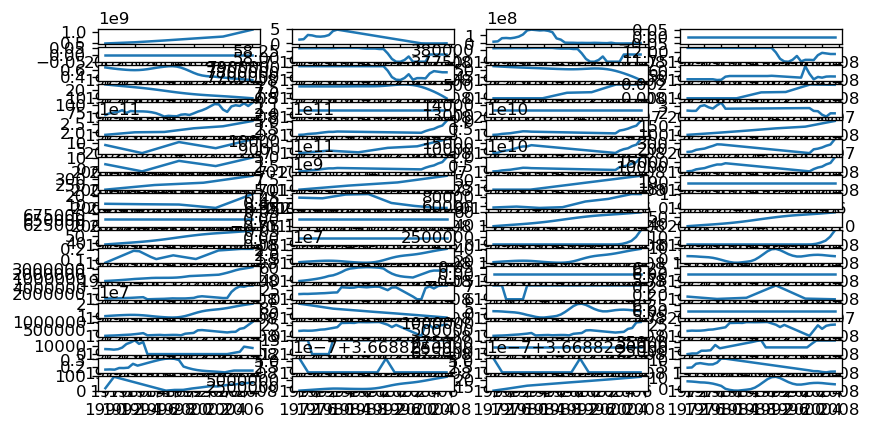

In [30]:
fig, axes = plt.subplots(nrows = 50, ncols = 4, dpi = 120, figsize = (8, 4))
for i, ax in enumerate(axes.flatten()):
    data = afghani[afghani.columns[i]]
    ax.plot(data)
    
plt.tight_layout()

#Flip the time interpolated multivariate series and use VAR for imputation


In [26]:
def get_all_nan_cols(dataframe):
    '''
    See which columns have no recorded values
    
    args:
        dataframe -- a specific country's dataframe
    
    returns:
        all_nan_col_list -- list of (string) column names 
        
    '''
    
    #get nan value count for each column
    col_nan_counter = dataframe.isnull().sum().tolist()

    #number of values in each column
    all_nan = dataframe.shape[0]

    col_names = dataframe.columns.tolist()
    
    all_nan_col_list = []

    for i in range(len(col_nan_counter)):
        if (col_nan_counter[i] == all_nan):
            all_nan_col_list.append(col_names[i])
            
    return all_nan_col_list

In [19]:
'''--------------------------------------------------------------------------------------------------------------------------

                            Step 3: Remove indices from both target and feature 
                                        dataframes so they are model ready

--------------------------------------------------------------------------------------------------------------------------'''

#Create rows of feature vectors and target vectors with no indexing
features_X = X_features_filled.reset_index().drop(['Country Name', 'level_1'], axis = 1)
targets_y = targets.reset_index().drop(['Country Name','level_1'], axis = 1)

In [86]:
'''

            KNN Imputation of features

'''
from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors = 8, weights = 'distance')
features_filled_knn = imp.fit_transform(features_X)


In [20]:
'''--------------------------------------------------------------------------------------------------------------------------

                            Step 4: Split data into test and training sets and
                                        impute missing values

--------------------------------------------------------------------------------------------------------------------------'''

X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed, y_test, y_train = split_and_impute(features_X, targets_y, 'simple_median', 'fill_mean', 0.3)

t_check passed if false:  False


In [81]:
X_train_imputed

Series Name,"2005 PPP conversion factor, GDP (LCU per international $)","2005 PPP conversion factor, private consumption (LCU per international $)","Adjusted net enrollment rate, primary, female (% of primary school age children)","Adjusted net enrollment rate, primary, male (% of primary school age children)",Adjusted net national income (constant 2005 US$),Adjusted net national income (current US$),Adjusted net national income per capita (constant 2005 US$),Adjusted net national income per capita (current US$),Adjusted savings: carbon dioxide damage (% of GNI),Adjusted savings: carbon dioxide damage (current US$),...,Total tax rate (% of commercial profits),Trade (% of GDP),"Tuberculosis case detection rate (%, all forms)",Tuberculosis treatment success rate (% of registered cases),"Unemployment, female (% of female labor force) (national estimate)","Unemployment, male (% of male labor force) (national estimate)","Unemployment, total (% of total labor force) (national estimate)",Urban population,Urban population (% of total),Urban population growth (annual %)
0,3.434656,3.995192,89.97425,90.541265,1.671568e+10,6.161377e+09,2141.152131,1276.191597,0.356998,2.439995e+07,...,44.15,69.703915,72.0,77.0,8.9,7.0,7.8,12973.0,84.2920,2.126828
1,3.434656,3.995192,89.97425,90.541265,4.724360e+09,6.057813e+09,130.888928,167.832375,0.082452,5.987710e+06,...,44.15,19.775761,72.0,77.0,8.9,7.0,7.8,3832723.0,10.6186,4.376267
2,287.423106,436.285174,89.97425,90.541265,1.671568e+10,6.161377e+09,2141.152131,1276.191597,0.916664,3.825252e+07,...,44.10,214.645231,72.0,77.0,8.9,7.0,7.8,234668.0,38.8750,3.005495
3,3.434656,3.995192,89.97425,90.541265,7.374491e+09,5.350230e+09,1815.929889,1317.466204,1.314619,7.786068e+07,...,44.15,118.308790,86.0,90.0,8.9,7.0,7.8,3132566.0,77.1378,5.495251
4,3.434656,3.995192,89.97425,90.541265,1.671568e+10,6.161377e+09,2141.152131,1276.191597,0.356998,1.346818e+09,...,44.15,69.703915,72.0,77.0,8.9,7.0,7.8,20663601.0,58.0860,1.894120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5387,3.434656,3.995192,89.97425,90.541265,1.448419e+10,1.396891e+10,580.727961,560.068673,0.055454,8.479203e+06,...,44.15,21.546122,72.0,77.0,8.9,7.0,7.8,7241146.0,29.0326,2.322193
5388,3.434656,3.995192,88.75488,86.551440,9.603735e+10,1.258189e+11,1080.582414,1415.675246,0.413233,6.134894e+08,...,49.10,86.619409,55.0,89.0,7.1,7.6,7.4,42908226.0,48.2790,1.967525
5389,3.434656,3.995192,87.70409,86.809340,1.671568e+10,6.161377e+09,2141.152131,1276.191597,0.268499,9.560527e+06,...,44.15,80.954985,12.0,80.0,8.9,7.0,7.8,2291271.0,72.6242,2.856446
5390,3.434656,3.995192,99.24011,98.261500,2.160008e+10,1.351389e+10,1453.675051,909.478064,4.673942,1.098808e+09,...,44.15,94.031686,65.0,78.0,11.2,7.5,9.3,8220713.0,55.3250,-0.360328


In [32]:
'''------------------------------------------------------------------------------------------------------------------------

                                    Step 5.1: MultiOutput Regression

-------------------------------------------------------------------------------------------------------------------------'''

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Get a list of multioutput regressors
mo_regressors = [("KNeighbors", KNeighborsRegressor()), ("Linear Regression", LinearRegression()), ("Random Forest", RandomForestRegressor(n_estimators = 25))]
prediction_dict = {}
cost_dict = {}

print("Starting MultiOutput Regression with multiple models . . .")

#Fit each model to imputed training data, then predict
for model in mo_regressors:
    model[1].fit(X_train_imputed, y_train_imputed)
    print("Fit " + model[0])
    
    prediction_dict[model[0]] = model[1].predict(X_test_imputed)
    print("Predictions made with " + model[0])
    
print("Calculating errors . . . ")
#5 - calculate error for each model 
for prediction in prediction_dict:
    
    y_hat = prediction_dict[prediction]
    
    unimp_cost_sq, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'squared')
    unimp_cost_abs, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'absolute')
    imp_cost_sq = mean_squared_error(y_hat, y_test_imputed)
    imp_cost_abs = mean_absolute_error(y_hat, y_test_imputed)
    
    cost_dict[prediction + "_unimputed_cost_sq"] = unimp_cost_sq
    cost_dict[prediction + "_unimputed_cost_abs"] = unimp_cost_sq
    cost_dict[prediction + "_imputed_cost_sq"] = imp_cost_sq
    cost_dict[prediction + "_imputed_cost_abs"] = imp_cost_sq
    
    print("Error analysis for %s complete" % prediction)

Starting MultiOutput Regression with multiple models . . .
Fit KNeighbors
Predictions made with KNeighbors
Fit Linear Regression
Predictions made with Linear Regression
Fit Random Forest
Predictions made with Random Forest
Calculating errors . . . 
Error analysis for KNeighbors complete
Error analysis for Linear Regression complete
Error analysis for Random Forest complete


In [40]:
#Print results for multioutput models
print("Sorted in ascending order: \n")
for cost in sorted(cost_dict, key=cost_dict.get, reverse=False):
    print(cost, cost_dict[cost])

Sorted in ascending order: 

Random Forest_unimputed_cost_sq 0.00024850357247355084
Random Forest_unimputed_cost_abs 0.00024850357247355084
Random Forest_imputed_cost_sq 0.0004263198826012303
Random Forest_imputed_cost_abs 0.0004263198826012303
KNeighbors_unimputed_cost_sq 0.0005737431992566561
KNeighbors_unimputed_cost_abs 0.0005737431992566561
Linear Regression_unimputed_cost_sq 0.0008768988241961517
Linear Regression_unimputed_cost_abs 0.0008768988241961517
Linear Regression_imputed_cost_sq 0.0013353689446488543
Linear Regression_imputed_cost_abs 0.0013353689446488543
KNeighbors_imputed_cost_sq 0.001883435669439019
KNeighbors_imputed_cost_abs 0.001883435669439019


In [ ]:
Random Forest_unimputed_cost_sq 0.0001655662543860639
Random Forest_unimputed_cost_abs 0.0001655662543860639
Random Forest_imputed_cost_sq 0.0003427480761347908
Random Forest_imputed_cost_abs 0.0003427480761347908
KNeighbors_unimputed_cost_sq 0.0005737431992566561
KNeighbors_unimputed_cost_abs 0.0005737431992566561
Linear Regression_unimputed_cost_sq 0.0008768644934505436
Linear Regression_unimputed_cost_abs 0.0008768644934505436
Linear Regression_imputed_cost_sq 0.001335331308048639
Linear Regression_imputed_cost_abs 0.001335331308048639
KNeighbors_imputed_cost_sq 0.001883435669439014
KNeighbors_imputed_cost_abs 0.001883435669439014

In [43]:
'''------------------------------------------------------------------------------------------------------------------------

                                Step 5.2: Wrapper MultiOutput Regression

-------------------------------------------------------------------------------------------------------------------------'''

from sklearn.multioutput import MultiOutputRegressor
#from sklearn.svm import LinearSVM

#Get a list of multioutput regressors
mo_regressors = [("KNeighbors", KNeighborsRegressor()), ("Linear Regression", LinearRegression()), ("Random Forest 5", RandomForestRegressor(n_estimators = 5))]
prediction_dict = {}
cost_dict = {}

print("Starting Wrapper MultiOutput Regression with multiple models . . .")

#Fit each model to imputed training data, then predict
for model in mo_regressors:
    wrapper = MultiOutputRegressor(model[1])
    wrapper.fit(X_train_imputed, y_train_imputed)
    print("Fit " + model[0])
    
    prediction_dict[model[0]] = wrapper.predict(X_test_imputed)
    print("Predictions made with " + model[0])
    
print("Calculating errors . . . ")
#5 - calculate error for each model 
for prediction in prediction_dict:
    
    y_hat = prediction_dict[prediction]
    
    unimp_cost_sq, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'squared')
    unimp_cost_abs, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'absolute')
    imp_cost_sq = mean_squared_error(y_hat, y_test_imputed)
    imp_cost_abs = mean_absolute_error(y_hat, y_test_imputed)
    
    cost_dict[prediction + "_unimputed_cost_sq"] = unimp_cost_sq
    cost_dict[prediction + "_unimputed_cost_abs"] = unimp_cost_sq
    cost_dict[prediction + "_imputed_cost_sq"] = imp_cost_sq
    cost_dict[prediction + "_imputed_cost_abs"] = imp_cost_sq
    
    print("Error analysis for %s complete" % prediction)




Starting Wrapper MultiOutput Regression with multiple models . . .
Fit KNeighbors
Predictions made with KNeighbors
Fit Linear Regression
Predictions made with Linear Regression
Fit Random Forest
Predictions made with Random Forest
Calculating errors . . . 
Error analysis for KNeighbors complete
Error analysis for Linear Regression complete
Error analysis for Random Forest complete


In [44]:
#Print results for multioutput models
print("Sorted in ascending order: \n")
for cost in sorted(cost_dict, key=cost_dict.get, reverse=False):
    print(cost, cost_dict[cost])

Sorted in ascending order: 

Random Forest_unimputed_cost_sq 0.0001655662543860639
Random Forest_unimputed_cost_abs 0.0001655662543860639
Random Forest_imputed_cost_sq 0.0003427480761347908
Random Forest_imputed_cost_abs 0.0003427480761347908
KNeighbors_unimputed_cost_sq 0.0005737431992566561
KNeighbors_unimputed_cost_abs 0.0005737431992566561
Linear Regression_unimputed_cost_sq 0.0008768644934505436
Linear Regression_unimputed_cost_abs 0.0008768644934505436
Linear Regression_imputed_cost_sq 0.001335331308048639
Linear Regression_imputed_cost_abs 0.001335331308048639
KNeighbors_imputed_cost_sq 0.001883435669439014
KNeighbors_imputed_cost_abs 0.001883435669439014


In [65]:
#Random Forest with wrapper seems to work the best so far, lets see the results

#Get a list of multioutput regressors
mo_regressors = [("5", RandomForestRegressor(n_estimators = 5)), ("40", RandomForestRegressor(n_estimators = 20)), ("50", RandomForestRegressor(n_estimators = 30))]
prediction_dict = {}
cost_dict_wrapper_rf = {}

print("Starting Wrapper MultiOutput Regression with multiple models . . .")

#Fit each model to imputed training data, then predict
for model in mo_regressors:
    wrapper = MultiOutputRegressor(model[1])
    wrapper.fit(X_train_imputed, y_train_imputed)
    print("Fit " + model[0])
    
    prediction_dict[model[0]] = wrapper.predict(X_test_imputed)
    print("Predictions made with " + model[0])
    
print("Calculating errors . . . ")
#5 - calculate error for each model 
for prediction in prediction_dict:
    
    y_hat = prediction_dict[prediction]
    
    unimp_cost_sq, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'squared')
    unimp_cost_abs, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'absolute')
    imp_cost_sq = mean_squared_error(y_hat, y_test_imputed)
    imp_cost_abs = mean_absolute_error(y_hat, y_test_imputed)
    
    cost_dict_wrapper_rf[prediction + "_unimputed_cost_sq"] = unimp_cost_sq
    cost_dict_wrapper_rf[prediction + "_unimputed_cost_abs"] = unimp_cost_sq
    cost_dict_wrapper_rf[prediction + "_imputed_cost_sq"] = imp_cost_sq
    cost_dict_wrapper_rf[prediction + "_imputed_cost_abs"] = imp_cost_sq
    
    print("Error analysis for %s complete" % prediction)

Starting Wrapper MultiOutput Regression with multiple models . . .
Fit 5
Predictions made with 5
Fit 40
Predictions made with 40
Fit 50
Predictions made with 50
Calculating errors . . . 
Error analysis for 5 complete
Error analysis for 40 complete
Error analysis for 50 complete


In [67]:
print("Costs for Wrapped RF chains in ascending order: \n")
for cost in sorted(cost_dict_wrapper_rf, key=cost_dict_wrapper_rf.get, reverse=False):
    print(cost, cost_dict_wrapper_rf[cost])

Costs for Wrapped RF chains in ascending order: 

40_unimputed_cost_sq 0.00018890375409541776
40_unimputed_cost_abs 0.00018890375409541776
50_unimputed_cost_sq 0.00019362841067499422
50_unimputed_cost_abs 0.00019362841067499422
5_unimputed_cost_sq 0.0002025791072062601
5_unimputed_cost_abs 0.0002025791072062601
50_imputed_cost_sq 0.0002957962308763563
50_imputed_cost_abs 0.0002957962308763563
40_imputed_cost_sq 0.0003127915590301766
40_imputed_cost_abs 0.0003127915590301766
5_imputed_cost_sq 0.0003440171698737259
5_imputed_cost_abs 0.0003440171698737259


In [46]:
#Print results for multioutput models (only RFs)
print("Sorted in ascending order: \n")
for cost in sorted(cost_dict, key=cost_dict.get, reverse=False):
    print(cost, cost_dict[cost])

Sorted in ascending order: 

30_unimputed_cost_sq 0.00018489332356079274
30_unimputed_cost_abs 0.00018489332356079274
10_unimputed_cost_sq 0.00019181758552403423
10_unimputed_cost_abs 0.00019181758552403423
20_unimputed_cost_sq 0.0001977353535577782
20_unimputed_cost_abs 0.0001977353535577782
30_imputed_cost_sq 0.0002916004728958681
30_imputed_cost_abs 0.0002916004728958681
20_imputed_cost_sq 0.0003184641456247795
20_imputed_cost_abs 0.0003184641456247795
10_imputed_cost_sq 0.0003310955952671555
10_imputed_cost_abs 0.0003310955952671555


In [57]:
'''------------------------------------------------------------------------------------------------------------------------

                                    Step 5.1: MultiOutput Regression, RandForests

-------------------------------------------------------------------------------------------------------------------------'''

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Get a list of multioutput regressors
mo_regressors = [("RF - 5", RandomForestRegressor(n_estimators = 5)), ("RF - 10", RandomForestRegressor(n_estimators = 10)), ("RF - 25", RandomForestRegressor(n_estimators = 25)), ("RF - 50", RandomForestRegressor(n_estimators = 50))]
prediction_dict = {}
cost_dict = {}

print("Starting MultiOutput Regression with multiple models . . .")

#Fit each model to imputed training data, then predict
for model in mo_regressors:
    model[1].fit(X_train_imputed, y_train_imputed)
    print("Fit " + model[0])
    
    prediction_dict[model[0]] = model[1].predict(X_test_imputed)
    print("Predictions made with " + model[0])
    
print("Calculating errors . . . ")
#5 - calculate error for each model 
for prediction in prediction_dict:
    
    y_hat = prediction_dict[prediction]
    
    unimp_cost_sq, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'squared')
    unimp_cost_abs, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'absolute')
    imp_cost_sq = mean_squared_error(y_hat, y_test_imputed)
    imp_cost_abs = mean_absolute_error(y_hat, y_test_imputed)
    
    cost_dict[prediction + "_unimputed_cost_sq"] = unimp_cost_sq
    cost_dict[prediction + "_unimputed_cost_abs"] = unimp_cost_sq
    cost_dict[prediction + "_imputed_cost_sq"] = imp_cost_sq
    cost_dict[prediction + "_imputed_cost_abs"] = imp_cost_sq
    
    print("Error analysis for %s complete" % prediction)

Starting MultiOutput Regression with multiple models . . .
Fit RF - 5
Predictions made with RF - 5
Fit RF - 10
Predictions made with RF - 10
Fit RF - 25
Predictions made with RF - 25
Fit RF - 50
Predictions made with RF - 50
Calculating errors . . . 
Error analysis for RF - 5 complete
Error analysis for RF - 10 complete
Error analysis for RF - 25 complete
Error analysis for RF - 50 complete


In [58]:
print("Sorted in ascending order: \n")
for cost in sorted(cost_dict, key=cost_dict.get, reverse=False):
    print(cost, cost_dict[cost])

Sorted in ascending order: 

RF - 50_unimputed_cost_sq 0.0002192338663840749
RF - 50_unimputed_cost_abs 0.0002192338663840749
RF - 25_unimputed_cost_sq 0.00023770417743133778
RF - 25_unimputed_cost_abs 0.00023770417743133778
RF - 10_unimputed_cost_sq 0.00024591182754509085
RF - 10_unimputed_cost_abs 0.00024591182754509085
RF - 5_unimputed_cost_sq 0.0002962591446575591
RF - 5_unimputed_cost_abs 0.0002962591446575591
RF - 50_imputed_cost_sq 0.00040985957727066383
RF - 50_imputed_cost_abs 0.00040985957727066383
RF - 25_imputed_cost_sq 0.00042652525017828556
RF - 25_imputed_cost_abs 0.00042652525017828556
RF - 10_imputed_cost_sq 0.00044271670593964036
RF - 10_imputed_cost_abs 0.00044271670593964036
RF - 5_imputed_cost_sq 0.0005400330398534707
RF - 5_imputed_cost_abs 0.0005400330398534707


In [58]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

unimp_cost_sq, y_hat_filt, y_test_filt = compute_unimputed_cost(y_test, y_hat_knr, y_test_imputed, 'squared')
unimp_cost_abs, y_hat_filt, y_test_filt = compute_unimputed_cost(y_test, y_hat_knr, y_test_imputed, 'absolute')

imp_cost_sq = mean_squared_error(y_hat_knr, y_test_imputed)
imp_cost_abs = mean_absolute_error(y_hat_knr, y_test_imputed)

print('Imputed_abs: %f\nImputed_sq: %f\nUnimputed_abs: %f \nUnimputed_sq: %f' % (imp_cost_abs, imp_cost_sq, unimp_cost_abs, unimp_cost_sq))

y_hat_knr_train = my_model.predict(X_train_imputed)

train_unimp_cost_sq, y_hat_filt, y_test_filt = compute_unimputed_cost(y_train, y_hat_knr_train, y_train_imputed, 'squared')
train_unimp_cost_abs, y_hat_filt, y_test_filt = compute_unimputed_cost(y_train, y_hat_knr_train, y_train_imputed, 'absolute')

train_imp_cost_sq = mean_squared_error(y_hat_knr_train, y_train_imputed)
train_imp_cost_abs = mean_absolute_error(y_hat_knr_train, y_train_imputed)

print('Training:')
print('Imputed_abs: %f\nImputed_sq: %f\nUnimputed_abs: %f \nUnimputed_sq: %f' % (train_imp_cost_abs, train_imp_cost_sq, train_unimp_cost_abs, train_unimp_cost_sq))


Imputed_abs: 0.020290
Imputed_sq: 0.002063
Unimputed_abs: 0.013147 
Unimputed_sq: 0.000773
Training:
Imputed_abs: 0.010344
Imputed_sq: 0.001118
Unimputed_abs: 0.003624 
Unimputed_sq: 0.000349


In [64]:
'''-----------------------------------------------------------

    Step 5: Create model, fit, and predict 
    
                    CROSS VALIDATION

--------------------------------------------------------------'''

from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn import model_selection
from sklearn.linear_model import LinearRegression

targets_y = targets_y.fillna(targets_y.mean())
features_X = features_X.fillna(features_X.mean())

kfold = model_selection.KFold(n_splits=5)
wrapper = MultiOutputRegressor(RandomForestRegressor(n_estimators = 5))
scoring = 'r2'
results = model_selection.cross_val_score(wrapper, features_X, targets_y, cv=kfold, scoring=scoring)

#print("R^2: %.3f (%.3f)") % (results.mean(), results.std())

In [73]:
print(results)

[-1.22531852e+26 -1.01067766e+00 -1.29848336e+26 -7.61819831e+26
 -1.61826914e+27]


In [ ]:
y_hat[0:4]

In [ ]:
#Shapley Values : Determine which indicators of all of them have the greatest impact on determingin the targets, then build a model based
#    on thse specific indicators 

In [74]:
Idea: run seperate models for each target. As for projecting into the future, find a way to accurately interpolate a countries indicator values in the years 2008 and 2012, after deciding which are the best indicators to use (both shapley and threshold) and then create an indicator vector accordingly and predict its target value accordingly

SyntaxError: invalid syntax (<ipython-input-74-811a6f70c484>, line 1)

In [68]:
#Random Forest with wrapper seems to work the best so far, lets see the results

#Get a list of multioutput regressors
mo_regressors = [("5.1", RandomForestRegressor(n_estimators = 5)), ("5.2", RandomForestRegressor(n_estimators = 5)), ("5.3", RandomForestRegressor(n_estimators = 5))]
prediction_dict = {}
cost_dict_wrapper_rf = {}

print("Starting Wrapper MultiOutput Regression with multiple models . . .")

#Fit each model to imputed training data, then predict
for model in mo_regressors:
    wrapper = MultiOutputRegressor(model[1])
    wrapper.fit(X_train_imputed, y_train_imputed)
    print("Fit " + model[0])
    
    prediction_dict[model[0]] = wrapper.predict(X_test_imputed)
    print("Predictions made with " + model[0])
    
print("Calculating errors . . . ")
#5 - calculate error for each model 
for prediction in prediction_dict:
    
    y_hat = prediction_dict[prediction]
    
    unimp_cost_sq, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'squared')
    unimp_cost_abs, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'absolute')
    imp_cost_sq = mean_squared_error(y_hat, y_test_imputed)
    imp_cost_abs = mean_absolute_error(y_hat, y_test_imputed)
    
    cost_dict_wrapper_rf[prediction + "_unimputed_cost_sq"] = unimp_cost_sq
    cost_dict_wrapper_rf[prediction + "_unimputed_cost_abs"] = unimp_cost_sq
    cost_dict_wrapper_rf[prediction + "_imputed_cost_sq"] = imp_cost_sq
    cost_dict_wrapper_rf[prediction + "_imputed_cost_abs"] = imp_cost_sq
    
    print("Error analysis for %s complete" % prediction)

Starting Wrapper MultiOutput Regression with multiple models . . .
Fit 5.1
Predictions made with 5.1
Fit 5.2
Predictions made with 5.2
Fit 5.3
Predictions made with 5.3
Calculating errors . . . 
Error analysis for 5.1 complete
Error analysis for 5.2 complete
Error analysis for 5.3 complete


In [69]:
print("Costs for Wrapped RF chains in ascending order: \n")
for cost in sorted(cost_dict_wrapper_rf, key=cost_dict_wrapper_rf.get, reverse=False):
    print(cost, cost_dict_wrapper_rf[cost])

Costs for Wrapped RF chains in ascending order: 

5.1_unimputed_cost_sq 0.00020219146045926463
5.1_unimputed_cost_abs 0.00020219146045926463
5.3_unimputed_cost_sq 0.0002141678921231124
5.3_unimputed_cost_abs 0.0002141678921231124
5.2_unimputed_cost_sq 0.00023033362804312355
5.2_unimputed_cost_abs 0.00023033362804312355
5.1_imputed_cost_sq 0.00035328262512874815
5.1_imputed_cost_abs 0.00035328262512874815
5.3_imputed_cost_sq 0.0003748215087997964
5.3_imputed_cost_abs 0.0003748215087997964
5.2_imputed_cost_sq 0.0003976006991522238
5.2_imputed_cost_abs 0.0003976006991522238


In [35]:
'''------------------------------------------------------------------------------------------------------------------------

                                    Step 5.3: Fully Connected Neural Network (Keras)
                                    
                              *******UNDER CONSTRUcTION -- COME BACK LATER******

-------------------------------------------------------------------------------------------------------------------------'''

from keras.models import Sequential
from keras.layers import Dense

input_dim = 468
output_dim = 7

model = Sequential()
model.add(Dense(230, input_dim = input_dim, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(output_dim))
model.compile(loss = 'mse', optimizer = 'adam')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 230)               107870    
_________________________________________________________________
dense_8 (Dense)              (None, 50)                11550     
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 357       
Total params: 119,777
Trainable params: 119,777
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit(X_train_imputed.to_numpy(), y_train_imputed.to_numpy(), epochs = 50)

Epoch 1/50
5392/5392 [==============================] - 2s 397us/step - loss: nan
Epoch 2/50
5392/5392 [==============================] - 2s 322us/step - loss: nan
Epoch 3/50
1888/5392 [=========>....................] - ETA: 1s - loss: nan

KeyboardInterrupt: 

In [41]:
'''------------------------------------------------------------------------------------------------------------------------

                        FEATURE IMPORTANCE -- Attempt using Random Forest with Wrapper 
                                    
-------------------------------------------------------------------------------------------------------------------------'''
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

model = RandomForestRegressor(n_estimators = 5)
wrapper = MultiOutputRegressor(model)

wrapper.fit(X_train_imputed, y_train_imputed)
y_hat = wrapper.predict(X_test_imputed)


In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

unimp_cost_sq, x, y = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'squared')
unimp_cost_abs, x1, y1 = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'absolute')

In [47]:
print(unimp_cost_sq, unimp_cost_abs)

0.00027317196789823644 0.0064128424372455715


In [57]:
y_train_imputed.head()

Series Name,Achieve universal primary education,Combat HIV/AIDS,Combat malaria and other diseases,Develop a global partnership for development: Internet Use,Ensure environmental sustainability,Improve maternal health,Reduce child mortality
5118,0.854789,0.024114,0.045,0.099810,0.797787,0.000242,0.076061
2241,0.854789,0.024114,0.045,0.099810,0.797787,0.000242,0.237400
2157,0.854789,0.049000,0.045,0.011498,0.797787,0.000242,0.124800
3478,0.854789,0.024114,0.045,0.099810,0.969000,0.000242,0.032600
5480,0.854789,0.024114,0.045,0.099810,0.797787,0.000242,0.023800


In [65]:
import eli5
from eli5.sklearn import PermutationImportance

model.fit(X_train_imputed, y_train_imputed.iloc[:,4])
perm = PermutationImportance(model, random_state = 1).fit(X_train_imputed, y_train_imputed.iloc[:,4])
eli5.show_weights(perm, feature_names = X_train_imputed.columns.tolist())

Weight,Feature
1.2268 ± 0.0532,"Improved water source, rural (% of rural population with access)"
0.0479 ± 0.0057,Urban population (% of total)
0.0416 ± 0.0030,"Improved water source, urban (% of urban population with access)"
0.0376 ± 0.0011,Rural population (% of total population)
0.0175 ± 0.0038,"PM10, country level (micrograms per cubic meter)"
0.0173 ± 0.0045,GDP per capita (constant 2005 US$)
0.0134 ± 0.0013,"Labor force participation rate, male (% of male population ages 15+) (modeled ILO estimate)"
0.0096 ± 0.0024,Forest area (sq. km)
0.0075 ± 0.0001,"Improved sanitation facilities, rural (% of rural population with access)"
0.0071 ± 0.0004,"International tourism, receipts (current US$)"


In [ ]:
TODO: create model using all of the indicators, use shap and perm importance to pick the most importanr
    also try using lasso and ridge for regularization and see which parameters they pick
    also use multivariate forecasting to determine values of inidcators in 2008 and 2012. As an experiment, leave the targets in and compare the predictions with 
    the values from the models predictions
    lastly for imputation, group countries by region and/or by socioeconomic sphere, then seperate, impute, and append
    
    Later model, break down each target by the indicators that specifically correspond to it(check uN website), create seperate 
    indicator dataframes for each target, and impute all of those accordingly
    

## Ways to improve on this project:
    
    1. Multivariate Time Series Imputation         
        a. https://www.groundai.com/project/multivariate-time-series-imputation-with-variational-autoencoders/1
        b. a. https://papers.nips.cc/paper/7432-multivariate-time-series-imputation-with-generative-adversarial-networks.pdf